# Машинное обучение для физических процессов. Физически-информированные нейронные сети (PINN)

## Производные в физике

Все процессы в **физике** описываются через некоторые величины и скорости их изменения. Для формализации этого в математике имеется удачный инструмент — **производная**. Физический смысл производной — **скорость изменения** одной величины относительно другой.

Далее для удобства ограничимся задачами **механики**. Пусть рассматривается движение тела во времени $t$ вдоль оси $Ox$, тогда его координата задана функцией $x(t)$.

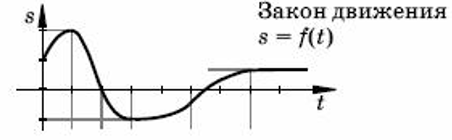

Тогда по определению **скорость тела** в момент времени $t$ — это отношение изменения коордианты тела $\Delta x$ к небольшому отрезку времени $\Delta t$, за которое это изменение произошло:

$$v(t)=\frac{\Delta x(t)}{\Delta t}, \quad \Delta t \rightarrow 0$$

То есть скорость — это **производная** координаты по времени. Для производной по времени, чтобы запись была компактной, принято ставить сверху точку или писать нижний индекс $t$:

$$v(t)=\frac{dx(t)}{dt} = \dot x = x_t$$

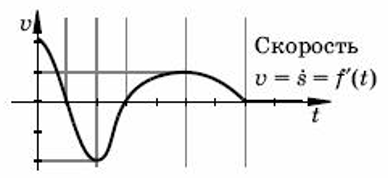

Аналогично **ускорение** — это производная скорости по времени, то есть вторая производная координаты по времени. Формула для ускорения выглядит так:

$$a(t)=\frac{dv(t)}{dt}=\frac{d^2 x(t)}{dt^2} = \ddot x = x_{tt}$$

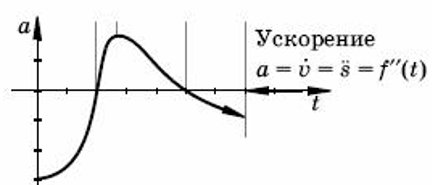

Как мы узнали, механизмы **автоматического дифференцирования**, то есть вычисления производных, реализованы в **`torch`**. Достаточно пометить тензор с параметром `requires_grad=True` и применить `torch.autograd.grad`, чтобы получить первую и вторую производные по времени.

##Пример падения в поле сил тяжести

Уравнения, содержащие производные, называются **дифференциальными уравнениями**. Результат решения дифференциального уравнения — **траектория**, то есть определённая зависимость функции, для которой мы считаем производные, от её аргументов.

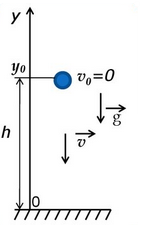

Например, уравнение движения при **равноускоренном падении**, то есть движения вдоль оси $y$ во времени $t$ с постоянным ускорением свободного падения $g$, направленным вниз, имеет вид:

$$y_{tt}= -g$$

Существует его аналитическое решение. Допустим, нам известны:

1. **Начальные условия** $(initial\ conditions,\ ic)$, то есть начальные координата $y_0$ и скорость $v_0$.

2. **Область изменения переменных**, в нашем примере $t > 0$ и $y \in (-\inf, \inf)$.

Тогда аналитическое **решение**:

$$y = y_0 + v_0 t - \frac{g t^2}{2}$$

##Граничные условия

Формула выше справедлива для всех точек из области определения. Заметим, что при описании равноускоренного движения границы области изменения переменных лежат на бесконечности. В ряде задач, например при описании колебаний струны или растяжения участка стержня длины $l$, закреплённых в точках $0$ и $l$, требуются **граничные условия** $(border\ conditions,\ bc)$.

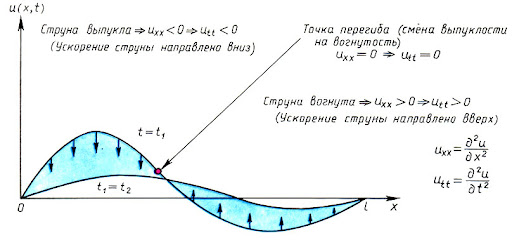

##Физически-информированные нейронные сети

###Устройство PINN

Вспомним, что **`MLP`** — это универсальный регрессор, способный улавливать нелинейные зависимости во входных данных и выдавать некоторый результат из непрерывного диапазона.

**Физически-информированная нейронная сеть** (`PINN`) — это полносвязная нейронная сеть, которая на вход получает переменные, от которых зависит функция, фигурирующая в дифференциальном уравнении, и предсказывающая значения этой функции от этих переменных.

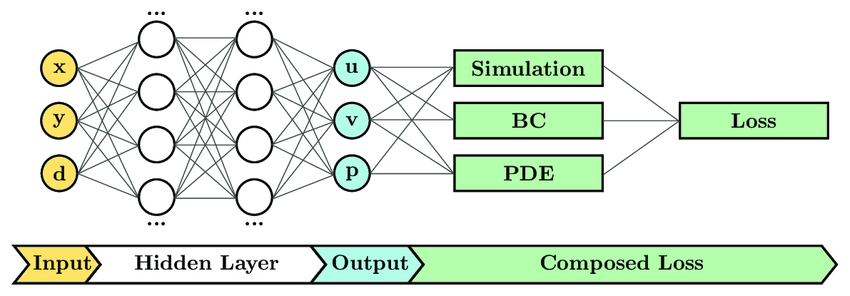

Традиционно `PINN` состоит из $4–8$ слоёв фиксированной ширины от $50$ до $100$ нейронов, функцией активации принимают $ReLU$, $GELU$ или $Tanh$. Такая структура позволяет сети не забывать фичи из-за слишком большой глубины и не терять информацию при переходе в более компактное представление.

###Обучение и loss в PINN

В нашем примере переменной является время $t$, а неизвестной функцией $x(t)$. Таким оразом, `PINN` не даёт аналитическое решение уравнение, а пытается приблизить неизвестную функцию, чтобы при передаче аргументов предсказывать её значения.

`PINN` **обучается** путём минимизации ошибки, например `MSE`, от трёх описанных выше источников для выполнения физичности предсказываемого решения:

1. На **внутренних** точках, путём минимизации разницы между левой и правой частями уравнения. Эту разницу называют **невязкой**. Если мы проверяем выполнение условий на $N_p$ внутренних точках, то:

$$\text{Loss}_{\text{PDE}} = \frac{1}{N_p} \sum_{i=1}^{N_p} \left( y_{tt} + g \right)^2$$

2. На **граничных** точках.
3. При **начальных** условиях:

$$\text{Loss}_{\text{IC}} = \frac{1}{N_{ic}} \left( \left( y(0) - y_0 \right)^2 + \left( y_t (0) - v_0 \right)^2 \right)$$

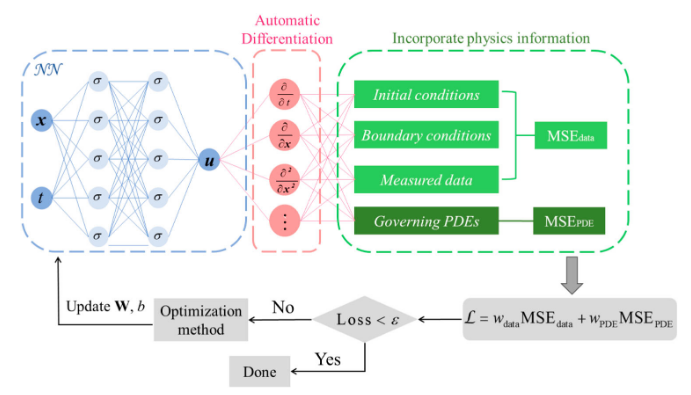

Суммарная **функция потерь**:

$$\text{Loss} = \text{Loss}_{\text{PDE}} + \text{Loss}_{\text{BC}} (=0) + \text{Loss}_{\text{IC}}$$

Очевидно, что потери от разных источников могут оказаться разных масштабов. Поэтому применяют **весовые множители**, которые приводят элементы суммы примерно к одному порядку:

$$\text{Loss} = \lambda_{\text{PDE}} \cdot \text{Loss}_{\text{PDE}} + \lambda_{\text{BC}} \cdot \text{Loss}_{\text{BC}} (=0) + \lambda_{\text{IC}} \cdot \text{Loss}_{\text{IC}}$$

###Тонкости обучения

Более того, функцию потерь можно дополнить некоторыми другими потерями, связанными с регрессией, классификацией и т. д. **Обучение** следует производить с $lr$, близким к $10^{-3}$, в течение порядка тысяч или десятков тысяч эпох. Весовые коэффициенты для слагаемых в функции потерь обновляют каждую тысячную эпоху.

`PINN` весьма **нестабильны** в обучении и требуют много времени. Ниже пример колебаний функций потерь при обучении на протяжении 25,000 эпох.

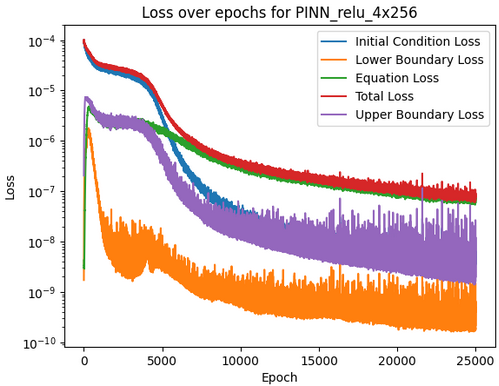

## Пример. PINN для описания равноускоренного движения

###Генерация данных

Реализуем `PINN` для решения описываемой задачи с равноускоренным движением. Положим, что тело движется от момента времени $0$ до $3$ секунды из начала координат без начальной скорости.

Импортируем основные модули.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Зададим параметры задачи.

In [50]:
g = 9.81
t_min, t_max = 0.0, 3.0

def y_exact(t):
    return - 0.5 * g * t**2

Сгенерируем значения времени в моменты, в которых будем проверять правильность предсказания модели. Эти значения называются $collocations$.

In [38]:
N_coll = 500
t_coll = torch.linspace(t_min, t_max, N_coll, device=device).unsqueeze(1)
t_coll.requires_grad = True

Начальный момент времени для проверки начальных условий. Размерность тензора как у $collocations$.

In [39]:
t0 = torch.zeros((5, 1), device=device, requires_grad=True)

Создадим датасеты и загрузчики данных.

In [41]:
from torch.utils.data import TensorDataset, DataLoader

coll_dataset = TensorDataset(t_coll)
coll_loader = DataLoader(coll_dataset, batch_size=32, shuffle=True)

ic_dataset = TensorDataset(t0)
ic_loader = DataLoader(ic_dataset, batch_size=1, shuffle=False)

###Моделирование

Решаемая задача простая. Создадим модель, принимающую на вход одно значение $t$, содержащей 2 скрытых слоя по 20 нейронов в ширину, предсказывающую одно значение $x$.

In [42]:
class PINN(nn.Module):
    def __init__(self, hidden=20):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, hidden),
            nn.Tanh(),
            nn.Linear(hidden, hidden),
            nn.Tanh(),
            nn.Linear(hidden, 1)
        )
    def forward(self, t):
        return self.net(t)

Модель, оптимизатор, потери.

In [43]:
model = PINN(hidden=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse = nn.MSELoss()

Функция для вычисления производных по $t$ через `autograd`. Задаём производные первого порядка, указывая тензоры, состоящие из единиц.

In [44]:
def derivatives(u, t):
    out = torch.ones_like(u)
    du_dt = torch.autograd.grad(u, t, grad_outputs=out, create_graph=True)[0]
    d2u_dt2 = torch.autograd.grad(du_dt, t, grad_outputs=out, create_graph=True)[0]
    return du_dt, d2u_dt2

Обучим модель. Увеличим `loss` на начальных условиях пропорционально потерям на $collocations$.

In [45]:
n_epochs = 5000
ic_weight = 100.0

In [46]:
from tqdm.auto import tqdm

history = []

for epoch in tqdm(range(n_epochs)):
    optimizer.zero_grad()

    # Потери на collocations
    loss_res = 0.0
    for (t_batch,) in coll_loader:
        t_batch = t_batch.detach().requires_grad_(True)

        u = model(t_batch)
        _, d2u = derivatives(u, t_batch)
        res = d2u + g
        loss_res += mse(res, torch.zeros_like(res))


    # Потери на начальных условиях
    for (t0_batch,) in ic_loader:
        t0_batch = t0_batch.detach().requires_grad_(True)
        u0 = model(t0_batch)
        du0 = torch.autograd.grad(
            u0, t0_batch,
            grad_outputs=torch.ones_like(u0),
            create_graph=True
        )[0]

        loss_ic = (
            mse(u0, torch.zeros_like(u0)) +
            mse(du0, torch.zeros_like(du0))
        )

    #Суммарные потери
    loss = loss_res + ic_weight * loss_ic
    history.append(loss.detach())

    # Обучение
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(
            f"epoch {epoch:4d} "
            f"loss={loss.item():.4e} "
            f"res={loss_res.item():.4e} "
            f"ic={loss_ic.item():.4e}"
        )

  0%|          | 0/5000 [00:00<?, ?it/s]

epoch    0 loss=1.5336e+03 res=1.5335e+03 ic=5.7469e-04
epoch  100 loss=1.4264e+03 res=1.3983e+03 ic=2.8046e-01
epoch  200 loss=1.2489e+03 res=1.2104e+03 ic=3.8547e-01
epoch  300 loss=1.0010e+03 res=9.6183e+02 ic=3.9218e-01
epoch  400 loss=8.4564e+02 res=8.0815e+02 ic=3.7490e-01
epoch  500 loss=7.2130e+02 res=6.9017e+02 ic=3.1132e-01
epoch  600 loss=6.2650e+02 res=5.9743e+02 ic=2.9069e-01
epoch  700 loss=5.4334e+02 res=5.1816e+02 ic=2.5177e-01
epoch  800 loss=4.7442e+02 res=4.5257e+02 ic=2.1850e-01
epoch  900 loss=4.0219e+02 res=3.8121e+02 ic=2.0983e-01
epoch 1000 loss=3.5273e+02 res=3.3573e+02 ic=1.6997e-01
epoch 1100 loss=2.9268e+02 res=2.7757e+02 ic=1.5109e-01
epoch 1200 loss=2.4817e+02 res=2.3501e+02 ic=1.3165e-01
epoch 1300 loss=2.1309e+02 res=2.0251e+02 ic=1.0586e-01
epoch 1400 loss=1.7639e+02 res=1.6769e+02 ic=8.7002e-02
epoch 1500 loss=1.4588e+02 res=1.3773e+02 ic=8.1560e-02
epoch 1600 loss=1.2167e+02 res=1.1550e+02 ic=6.1720e-02
epoch 1700 loss=1.0064e+02 res=9.4891e+01 ic=5.7

###Анализ результатов

Построим график потерь в ходе обучения в логарифмическом масштабе. Получили стабильную сходимость.

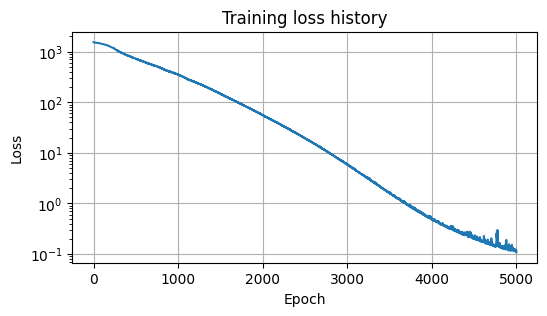

In [47]:
loss_np = torch.stack(history).cpu().numpy()

plt.figure(figsize=(6,3))
plt.plot(loss_np)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.title("Training loss history")
plt.show()

Сделаем предсказание.

In [52]:
model.eval()
t_test = torch.linspace(t_min, t_max, 300, device=device).unsqueeze(1)
with torch.no_grad():
    y_pred = model(t_test).cpu().numpy().squeeze()
t_np = t_test.cpu().numpy().squeeze()
y_ex = y_exact(t_np)

Выведем результат.

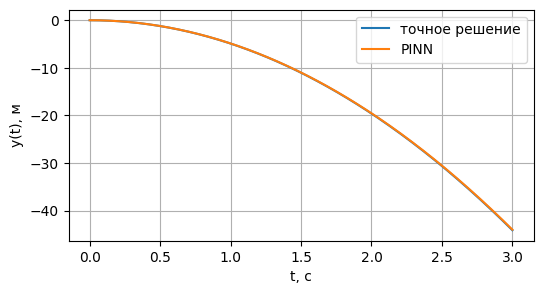

In [53]:
plt.figure(figsize=(6,3))
plt.plot(t_np, y_ex, label="точное решение")
plt.plot(t_np, y_pred, label="PINN")
plt.xlabel("t, с")
plt.ylabel("y(t), м")
plt.legend()
plt.grid(True)
plt.show()

Вычислим ошибку.

In [54]:
rel_L2 = np.linalg.norm(y_pred - y_ex) / np.linalg.norm(y_ex)
print("Относительная L2 ошибка:", rel_L2)

Относительная L2 ошибка: 0.0029686247


Построим график изменения ошибки с ростом времени от момента $0$ до $3$ секунды. Визуально наблюдаем хорошее соответствие начальным условиям с постепенным отклонением предсказания от ожидаемого аналитического решения. К $3$ секунде предсказание отклонилось на $12$ см.

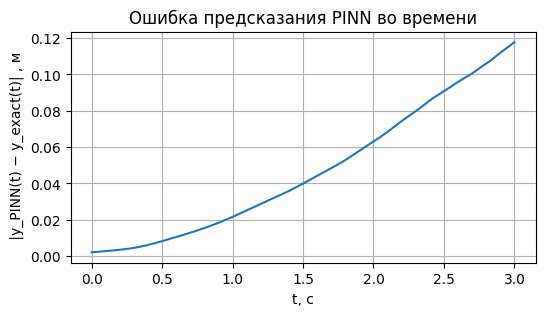

In [55]:
error = np.abs(y_pred - y_ex)

plt.figure(figsize=(6,3))
plt.plot(t_np, error)
plt.xlabel("t, с")
plt.ylabel(" |y_PINN(t) − y_exact(t)| , м")
plt.grid(True)
plt.title("Ошибка предсказания PINN во времени")
plt.show()


##Выводы

В ходе занятия мы:

1. Описали физический смысл производной.
2. Поставили задачу движения в поле сил тяжести и привели аналитическое решение.
3. Описали архитектуру `PINN`, источники в её функции потерь и тонкости обучения `PINN`.
4. Реализовали нейросеть для предсказания траектории движения в поле сил тяжести.

##Данные об авторе

Зюков Алексей Алексеевич,

лаборант отдела-онлайн образования НИЯУ МИФИ,

бакалавр кафедры суперкомпьютерных технологий в инженерно-физическом моделировании НИЯУ МИФИ.

##Список использованной и рекомендованной литературы


1. Иродов, И. Е. Механика : учебное пособие для вузов / И. Е. Иродова. — 16-е изд. — Москва : Лаборатория знаний, 2023. — 309 с. — Текст : непосредственный.
2. Савельев, И. В. Курс общей физики. В 5 томах. Том 1. Механика : учебное пособие. — Текст : электронный. / И. В. Савельев. — 10-е изд., стер. — Санкт-Петербург : Лань, 2025. — 352 с. — URL: https://e.lanbook.com/book/153686 (дата обращения: 01.11.2025). — Режим доступа: для авториз. пользователей.
3. An Expert's Guide to Training Physics-informed Neural Networks / S. Wang, S. Sankaran, H. Wang, P. Perdikaris. — Текст : электронный // arXiv.org : [сайт]. — 2023. — 16 August. — URL: https://arxiv.org/abs/2308.08468 (дата обращения: 01.11.2025).

